# Imports and variable setup

In [12]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import plotly.express as px
import pandas as pd
import numpy as np
import os

import datetime 

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from utils import filter_by_rule, detect_outliers_z_score, report_results, run_dbscan, \
    get_kdist_plot, dbscan_predict, calculate_adjusted_density, evaluate_classifier, \
    get_distance, remove_outliers_and_normalize, evaluate_clustering
from config import *
import pickle


import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning, FutureWarning, UserWarning))

from DSClassifierMultiQ import DSClassifierMultiQ

import pickle

In [13]:
import logging


if not os.path.exists("logs"):
    os.mkdir("logs")

log_file = os.path.join("logs", "api.log")

rfh = logging.handlers.RotatingFileHandler(
    filename=log_file,
    mode='a',
    maxBytes=LOGGING_MAX_SIZE_MB*1024*1024,
    backupCount=LOGGING_BACKUP_COUNT,
    encoding=None,
    delay=0
)

logging.getLogger('matplotlib.font_manager').disabled = True

console_handler = logging.StreamHandler()

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%y-%m-%d %H:%M:%S",
    handlers=[
        rfh,
        console_handler
    ],
)

logger = logging.getLogger(__name__)

In [14]:
#  https://www.kaggle.com/datasets/jakeshbohaju/brain-tumor/data
DATASET_FOLDER = "datasets" 

assert os.path.exists(DATASET_FOLDER), "Dataset folder not found"

datasets = os.listdir(DATASET_FOLDER)
logging.info(f"Found {len(datasets)} datasets")

24-04-28 00:02:42 [INFO] Found 6 datasets


# All in one cell

In [18]:
def do_all_for_dataset(dataset, nrows=None, ratio_deviation=0.1, label_col_for_dist=LABEL_COL_FOR_DIST):
    dataset_name = dataset.split(".")[0]
    if nrows:
        data = pd.read_csv(os.path.join(DATASET_FOLDER, dataset)).sample(nrows)
    else:
        data = pd.read_csv(os.path.join(DATASET_FOLDER, dataset))    
    
    data.head(2)

    logger.debug(f"Dataset: {dataset_name} | Shape: {data.shape}")
    # if missing more than 20% of the data, drop the column
    missing_threshold = 0.2
    data = data.dropna(thresh=len(data) * (1 - missing_threshold), axis=1)
    logger.debug(f"{data.shape} droped columns with more than {missing_threshold*100:.0f}% missing values")
    # drop rows with missing values
    data = data.dropna()
    logger.debug(f"{data.shape} drop rows with missing values")

    assert data.isna().sum().sum() == 0, "Dataset contains missing values"
    assert "labels" in data.columns, "Dataset does not contain `labels` column"
    assert data.labels.nunique() == 2, f"Dataset labels are not binary ({data.labels.unique()})"

    label_ratio = data.labels.value_counts(normalize=True).iloc[0]
    assert abs(label_ratio -0.5) < ratio_deviation, f"Label ratio is not balanced ({label_ratio})"

    # leave only numeric columns
    data = data.select_dtypes(include=[np.number])
    logger.debug(f"{data.shape} drop non-numeric columns")

    # move labels column to the end 
    data = data[[col for col in data.columns if col != "labels"] + ["labels"]]

    logging.info(f"------ Dataset: {dataset_name} | Shape: {data.shape} | Label ratio: {label_ratio:.2f} -------")

    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    data = data.apply(pd.to_numeric)
    cut = int(train_set_size*len(data))

    train_data_df = data.iloc[:cut]
    test_data_df = data.iloc[cut:]

    X_train = data.iloc[:cut, :-1].values
    y_train = data.iloc[:cut, -1].values
    X_test = data.iloc[cut:, :-1].values
    y_test = data.iloc[cut:, -1].values

    logging.info(f"Step 0: Data split done | {len(X_train)} - {len(X_test)}")


    st_scaler = StandardScaler().fit(train_data_df)
    # break
    scale = st_scaler.scale_
    mean = st_scaler.mean_
    var = st_scaler.var_ 

    X_train_scaled = st_scaler.transform(train_data_df)
    X_test_scaled = st_scaler.transform(test_data_df)  #! during inference we won't have this

    logging.debug("Step 1: Standard scaling complete")

    # CLUSTERING_ALG = "dbscan" # in future we'll add DBSCAN
    CLUSTERING_ALG = "kmeans" # in future we'll add DBSCAN

    logging.info(f"Step 2.1: Performing {CLUSTERING_ALG} clustering")


    db_eps = None # if DBSCAN then will get overriden
    if CLUSTERING_ALG == "kmeans":
        clustering_model = KMeans(n_clusters=2, random_state=42, n_init="auto")      
        clustering_model.fit(X_train_scaled)  
        
        clustering_labels_train = clustering_model.predict(X_train_scaled)
        clustering_labels_test = clustering_model.predict(X_test_scaled)
    else:
        clustering_model = run_dbscan(X_train_scaled, eps=0.01, max_eps=20, min_samples=2, step=0.05) #*X_train.shape[1] - 1)
        if clustering_model is None:
            logging.warning(f"Could not find the desired number of clusters for {dataset_name}")
            raise Exception("Clustering failed")
        
        clustering_labels_train = dbscan_predict(clustering_model, X_train_scaled)
        clustering_labels_test = dbscan_predict(clustering_model, X_test_scaled)
        
        db_eps = clustering_model.eps
        


    train_data_df["labels_clustering"] = clustering_labels_train
    test_data_df["labels_clustering"] = clustering_labels_test

    logger.info(f"Step 2.1: Clustering and inference done")
        
    evaluate_clustering(X_train_scaled, clustering_labels_train, clustering_model, 
                        CLUSTERING_ALG, print_results=True)
    evaluate_clustering(X_test_scaled, clustering_labels_test, clustering_model, 
                        CLUSTERING_ALG, print_results=True, dataset="test")

    logging.info("Step 2.2: Clustering evaluation done")

    evaluate_classifier(y_actual=y_train, y_clust=clustering_labels_train, 
                        dataset="train", print_results=True)
    evaluate_classifier(y_actual=y_test, y_clust=clustering_labels_test, 
                        dataset="test", print_results=True)

    logger.info("Step 3: Clustering as a classifier, evaluation done")

    train_data_df["distance"] = get_distance(X_train_scaled, clustering_model, CLUSTERING_ALG, density_radius=db_eps)
    test_data_df["distance"] = get_distance(X_test_scaled, clustering_model, CLUSTERING_ALG, density_radius=db_eps)

    train_data_df["distance_norm"] = remove_outliers_and_normalize(train_data_df, label_column="labels_clustering") 
    test_data_df["distance_norm"] = remove_outliers_and_normalize(test_data_df, label_column="labels_clustering")

    assert train_data_df.isna().sum().sum() == 0, "Train data contains NaNs"
    assert test_data_df.isna().sum().sum() == 0, "Train data contains NaNs"

    logger.info(f"Step 4: Distance calculation done")

    num_breaks = 3
    mult_rules = False
    debug_mode = True
    print_final_model = True
    num_workers = 0

    RULE_FOLDER = "rules_saved_clean"

    ignore_for_training = ["labels_clustering", "distance_norm"]
    df_cols = [i for i in list(data.columns) if i not in ignore_for_training]

    rows_use = None
    if rows_use:
        train_data_df_use = train_data_df.head(rows_use)
        X_train_use = X_train[:rows_use]
        y_train_use = y_train[:rows_use]
    else:
        train_data_df_use = train_data_df
        X_train_use = X_train
        y_train_use = y_train
    logger.debug(f"Train: {len(X_train_use)}")
    for method in ["clustering", "random"]:
        name = f"dataset={dataset_name}, label_for_dist={LABEL_COL_FOR_DIST}, clust={CLUSTERING_ALG}, breaks={num_breaks}, add_mult_rules={mult_rules}, maf_method={method}"
        logger.info(f"Step 5: Run DST ({name})")
        DSC = DSClassifierMultiQ(2, debug_mode=debug_mode, num_workers=num_workers, maf_method=method,
                                data=train_data_df_use, precompute_rules=True, )#.head(rows_use))
        logger.debug(f"\tModel init done")    
        res = DSC.fit(X_train_use, y_train_use, 
                add_single_rules=True, single_rules_breaks=num_breaks, add_mult_rules=mult_rules,
                column_names=df_cols, print_every_epochs=1, print_final_model=print_final_model)
        losses, epoch, dt = res
        logger.debug(f"\tModel fit done")

        DSC.model.save_rules_bin(os.path.join(RULE_FOLDER, f"{name}.dsb"))
    #     most_important_rules = DSC.model.find_most_important_rules()
    #     print(most_important_rules)
        DSC.model.print_most_important_rules()
        y_pred = DSC.predict(X_test)

        logger.info(f"Step 6: Inference done")

        report_results(y_test, y_pred, dataset=dataset_name, method=method,
                    epoch=epoch, dt=dt, losses=losses, 
                    save_results=True, name=name, print_results=True,
                    breaks=num_breaks, mult_rules=mult_rules, clustering_alg=CLUSTERING_ALG, label_for_dist=LABEL_COL_FOR_DIST)
        logging.info("-"*30)
        
        

  0%|          | 0/6 [00:00<?, ?it/s]24-04-28 00:04:46 [DEBUG] Dataset: Brain Tumor | Shape: (3762, 14)
24-04-28 00:04:46 [DEBUG] (3762, 14) droped columns with more than 20% missing values
24-04-28 00:04:46 [DEBUG] (3762, 14) drop rows with missing values
24-04-28 00:04:46 [DEBUG] (3762, 14) drop non-numeric columns
24-04-28 00:04:46 [INFO] ------ Dataset: Brain Tumor | Shape: (3762, 14) | Label ratio: 0.55 -------
24-04-28 00:04:46 [INFO] Step 0: Data split done | 2633 - 1129
24-04-28 00:04:46 [DEBUG] Step 1: Standard scaling complete
24-04-28 00:04:46 [INFO] Step 2.1: Performing kmeans clustering
24-04-28 00:04:46 [INFO] Step 2.1: Clustering and inference done
24-04-28 00:04:46 [DEBUG] Evaluation on train
24-04-28 00:04:46 [DEBUG] 	silhouette = 0.378
24-04-28 00:04:46 [DEBUG] 	calinski_harabasz = 1373.973
24-04-28 00:04:46 [DEBUG] 	inertia = 22486.171
24-04-28 00:04:46 [DEBUG] Evaluation on test
24-04-28 00:04:46 [DEBUG] 	silhouette = 0.381
24-04-28 00:04:46 [DEBUG] 	calinski_haraba

Optimization started
Processing epoch	117	0.0178	

24-04-28 00:08:37 [DEBUG] 	Model fit done



Training time: 226.09s, epochs: 117

Least training loss reached: 0.018
DSModelMultiQ(
  DS Classifier using 49 rules
  
  Rule 1: Mean < 5.660
  	C1: 0.065	C2: 0.750	Unc: 0.185
  
  Rule 2: 5.660 < Mean < 9.563
  	C1: 0.428	C2: 0.293	Unc: 0.279
  
  Rule 3: 9.563 < Mean < 13.466
  	C1: 0.487	C2: 0.256	Unc: 0.257
  
  Rule 4: Mean > 13.466
  	C1: 0.662	C2: 0.162	Unc: 0.176
  
  Rule 5: Variance < 396.340
  	C1: 0.556	C2: 0.201	Unc: 0.243
  
  Rule 6: 396.340 < Variance < 708.627
  	C1: 0.450	C2: 0.274	Unc: 0.276
  
  Rule 7: 708.627 < Variance < 1020.914
  	C1: 0.448	C2: 0.281	Unc: 0.271
  
  Rule 8: Variance > 1020.914
  	C1: 0.132	C2: 0.654	Unc: 0.213
  
  Rule 9: Standard Deviation < 19.243
  	C1: 0.530	C2: 0.217	Unc: 0.254
  
  Rule 10: 19.243 < Standard Deviation < 25.142
  	C1: 0.477	C2: 0.261	Unc: 0.263
  
  Rule 11: 25.142 < Standard Deviation < 31.042
  	C1: 0.420	C2: 0.295	Unc: 0.285
  
  Rule 12: Standard Deviation > 31.042
  	C1: 0.107	C2: 0.689	Unc: 0.203
  
  Rule 13: En

24-04-28 00:08:38 [INFO] Step 6: Inference done
24-04-28 00:08:38 [DEBUG] Training Time: 226.09s
24-04-28 00:08:38 [DEBUG] Epochs: 117
24-04-28 00:08:38 [DEBUG] Min Loss: 0.018


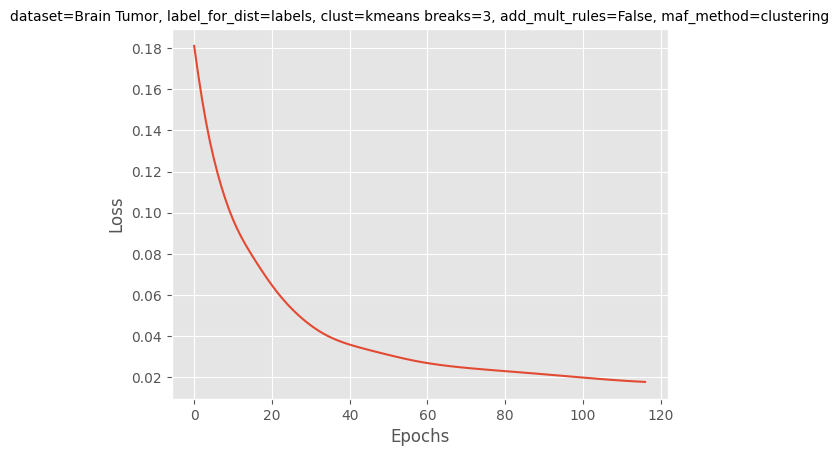

24-04-28 00:08:39 [DEBUG] Accuracy:  0.98
24-04-28 00:08:39 [DEBUG] F1 Score: 0.98
24-04-28 00:08:39 [DEBUG] Confusion Matrix: 
[[606   5]
 [ 16 502]]
24-04-28 00:08:39 [INFO] ------------------------------
24-04-28 00:08:39 [INFO] Step 5: Run DST (dataset=Brain Tumor, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=random)
24-04-28 00:08:39 [DEBUG] 	Model init done


Optimization started
Processing epoch	141	0.0263	

24-04-28 00:14:25 [DEBUG] 	Model fit done



Training time: 345.85s, epochs: 141

Least training loss reached: 0.026
DSModelMultiQ(
  DS Classifier using 49 rules
  
  Rule 1: Mean < 5.660
  	C1: 0.000	C2: 0.353	Unc: 0.647
  
  Rule 2: 5.660 < Mean < 9.563
  	C1: 0.000	C2: 0.227	Unc: 0.773
  
  Rule 3: 9.563 < Mean < 13.466
  	C1: 0.120	C2: 0.061	Unc: 0.819
  
  Rule 4: Mean > 13.466
  	C1: 0.248	C2: 0.000	Unc: 0.752
  
  Rule 5: Variance < 396.340
  	C1: 0.211	C2: 0.000	Unc: 0.789
  
  Rule 6: 396.340 < Variance < 708.627
  	C1: 0.174	C2: 0.017	Unc: 0.809
  
  Rule 7: 708.627 < Variance < 1020.914
  	C1: 0.052	C2: 0.138	Unc: 0.810
  
  Rule 8: Variance > 1020.914
  	C1: 0.000	C2: 0.355	Unc: 0.645
  
  Rule 9: Standard Deviation < 19.243
  	C1: 0.274	C2: 0.000	Unc: 0.726
  
  Rule 10: 19.243 < Standard Deviation < 25.142
  	C1: 0.169	C2: 0.014	Unc: 0.818
  
  Rule 11: 25.142 < Standard Deviation < 31.042
  	C1: 0.093	C2: 0.094	Unc: 0.813
  
  Rule 12: Standard Deviation > 31.042
  	C1: 0.000	C2: 0.265	Unc: 0.735
  
  Rule 13: En

24-04-28 00:14:25 [INFO] Step 6: Inference done
24-04-28 00:14:25 [DEBUG] Training Time: 345.85s
24-04-28 00:14:25 [DEBUG] Epochs: 141
24-04-28 00:14:25 [DEBUG] Min Loss: 0.026


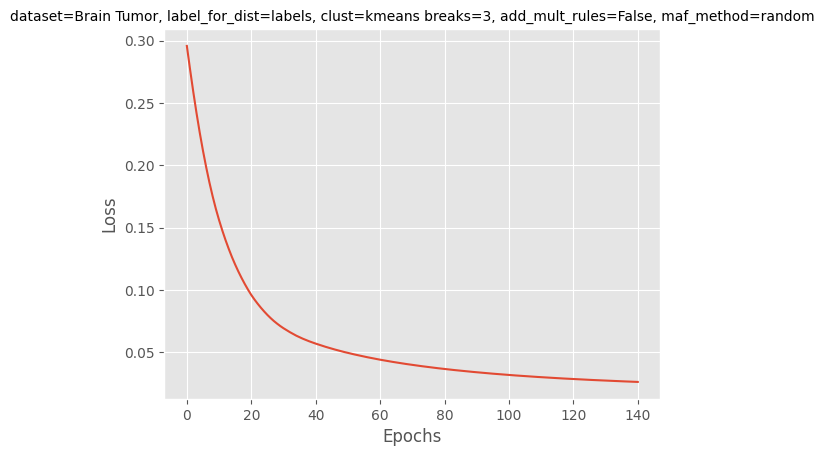

24-04-28 00:14:26 [DEBUG] Accuracy:  0.98
24-04-28 00:14:26 [DEBUG] F1 Score: 0.98
24-04-28 00:14:26 [DEBUG] Confusion Matrix: 
[[608   3]
 [ 14 504]]
24-04-28 00:14:26 [INFO] ------------------------------
 17%|█▋        | 1/6 [09:40<48:23, 580.79s/it]24-04-28 00:14:26 [DEBUG] Dataset: breast-cancer-wisconsin | Shape: (683, 10)
24-04-28 00:14:26 [DEBUG] (683, 10) droped columns with more than 20% missing values
24-04-28 00:14:26 [DEBUG] (683, 10) drop rows with missing values
24-04-28 00:14:26 [DEBUG] (683, 10) drop non-numeric columns
24-04-28 00:14:26 [INFO] ------ Dataset: breast-cancer-wisconsin | Shape: (683, 10) | Label ratio: 0.65 -------
24-04-28 00:14:26 [INFO] Step 0: Data split done | 478 - 205
24-04-28 00:14:26 [DEBUG] Step 1: Standard scaling complete
24-04-28 00:14:26 [INFO] Step 2.1: Performing kmeans clustering
24-04-28 00:14:26 [INFO] Step 2.1: Clustering and inference done
24-04-28 00:14:26 [DEBUG] Evaluation on train
24-04-28 00:14:26 [DEBUG] 	silhouette = 0.585
24-

Optimization started
Processing epoch	73	0.0228	

24-04-28 00:15:00 [DEBUG] 	Model fit done
24-04-28 00:15:00 [INFO] Step 6: Inference done
24-04-28 00:15:00 [DEBUG] Training Time: 31.66s
24-04-28 00:15:00 [DEBUG] Epochs: 73
24-04-28 00:15:00 [DEBUG] Min Loss: 0.023



Training time: 31.66s, epochs: 73

Least training loss reached: 0.023
DSModelMultiQ(
  DS Classifier using 36 rules
  
  Rule 1: clump_thickness < 2.569
  	C1: 0.725	C2: 0.112	Unc: 0.163
  
  Rule 2: 2.569 < clump_thickness < 4.454
  	C1: 0.639	C2: 0.184	Unc: 0.178
  
  Rule 3: 4.454 < clump_thickness < 6.339
  	C1: 0.568	C2: 0.222	Unc: 0.210
  
  Rule 4: clump_thickness > 6.339
  	C1: 0.075	C2: 0.590	Unc: 0.335
  
  Rule 5: size_uniformity < 1.066
  	C1: 0.820	C2: 0.020	Unc: 0.159
  
  Rule 6: 1.066 < size_uniformity < 3.100
  	C1: 0.370	C2: 0.334	Unc: 0.296
  
  Rule 7: 3.100 < size_uniformity < 5.134
  	C1: 0.060	C2: 0.662	Unc: 0.278
  
  Rule 8: size_uniformity > 5.134
  	C1: 0.141	C2: 0.534	Unc: 0.325
  
  Rule 9: shape_uniformity < 1.176
  	C1: 0.777	C2: 0.000	Unc: 0.223
  
  Rule 10: 1.176 < shape_uniformity < 3.136
  	C1: 0.447	C2: 0.290	Unc: 0.264
  
  Rule 11: 3.136 < shape_uniformity < 5.096
  	C1: 0.000	C2: 0.762	Unc: 0.238
  
  Rule 12: shape_uniformity > 5.096
  	C1: 0.1

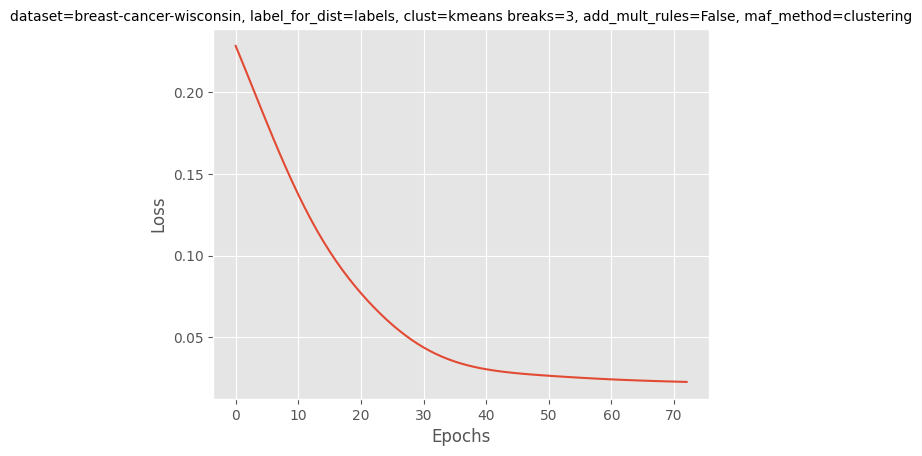

24-04-28 00:15:01 [DEBUG] Accuracy:  0.98
24-04-28 00:15:01 [DEBUG] F1 Score: 0.97
24-04-28 00:15:01 [DEBUG] Confusion Matrix: 
[[129   3]
 [  2  71]]
24-04-28 00:15:01 [INFO] ------------------------------
24-04-28 00:15:01 [INFO] Step 5: Run DST (dataset=breast-cancer-wisconsin, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=random)
24-04-28 00:15:01 [DEBUG] 	Model init done


Optimization started
Processing epoch	108	0.0287	

24-04-28 00:15:52 [DEBUG] 	Model fit done
24-04-28 00:15:53 [INFO] Step 6: Inference done
24-04-28 00:15:53 [DEBUG] Training Time: 51.57s
24-04-28 00:15:53 [DEBUG] Epochs: 108



Training time: 51.57s, epochs: 108

Least training loss reached: 0.029
DSModelMultiQ(
  DS Classifier using 36 rules
  
  Rule 1: clump_thickness < 2.569
  	C1: 0.373	C2: 0.000	Unc: 0.627
  
  Rule 2: 2.569 < clump_thickness < 4.454
  	C1: 0.318	C2: 0.000	Unc: 0.682
  
  Rule 3: 4.454 < clump_thickness < 6.339
  	C1: 0.148	C2: 0.021	Unc: 0.831
  
  Rule 4: clump_thickness > 6.339
  	C1: 0.000	C2: 0.405	Unc: 0.595
  
  Rule 5: size_uniformity < 1.066
  	C1: 0.231	C2: 0.000	Unc: 0.769
  
  Rule 6: 1.066 < size_uniformity < 3.100
  	C1: 0.000	C2: 0.250	Unc: 0.750
  
  Rule 7: 3.100 < size_uniformity < 5.134
  	C1: 0.000	C2: 0.354	Unc: 0.646
  
  Rule 8: size_uniformity > 5.134
  	C1: 0.000	C2: 0.344	Unc: 0.656
  
  Rule 9: shape_uniformity < 1.176
  	C1: 0.378	C2: 0.000	Unc: 0.622
  
  Rule 10: 1.176 < shape_uniformity < 3.136
  	C1: 0.141	C2: 0.041	Unc: 0.818
  
  Rule 11: 3.136 < shape_uniformity < 5.096
  	C1: 0.000	C2: 0.460	Unc: 0.540
  
  Rule 12: shape_uniformity > 5.096
  	C1: 0.

24-04-28 00:15:53 [DEBUG] Min Loss: 0.029


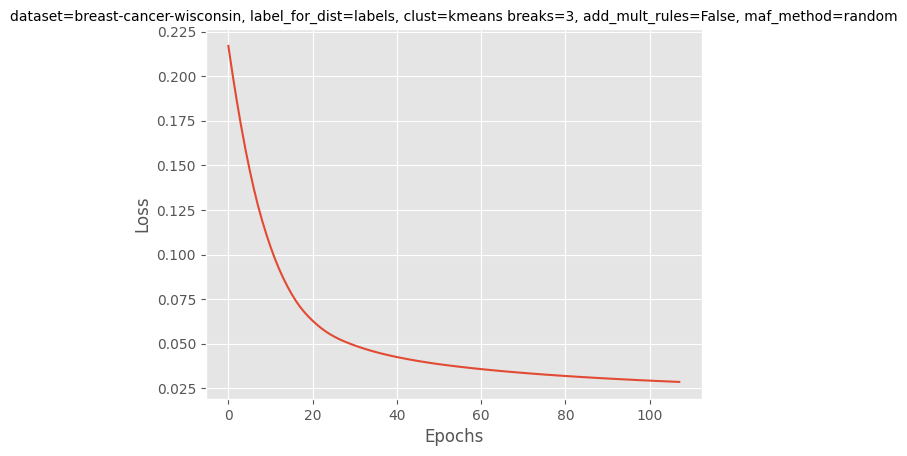

24-04-28 00:15:53 [DEBUG] Accuracy:  0.98
24-04-28 00:15:53 [DEBUG] F1 Score: 0.97
24-04-28 00:15:53 [DEBUG] Confusion Matrix: 
[[129   3]
 [  2  71]]
24-04-28 00:15:54 [INFO] ------------------------------
 33%|███▎      | 2/6 [11:08<19:21, 290.46s/it]24-04-28 00:15:54 [DEBUG] Dataset: gaussian_df | Shape: (500, 3)
24-04-28 00:15:54 [DEBUG] (500, 3) droped columns with more than 20% missing values
24-04-28 00:15:54 [DEBUG] (500, 3) drop rows with missing values
24-04-28 00:15:54 [DEBUG] (500, 3) drop non-numeric columns
24-04-28 00:15:54 [INFO] ------ Dataset: gaussian_df | Shape: (500, 3) | Label ratio: 0.50 -------
24-04-28 00:15:54 [INFO] Step 0: Data split done | 350 - 150
24-04-28 00:15:54 [DEBUG] Step 1: Standard scaling complete
24-04-28 00:15:54 [INFO] Step 2.1: Performing kmeans clustering
24-04-28 00:15:54 [INFO] Step 2.1: Clustering and inference done
24-04-28 00:15:54 [DEBUG] Evaluation on train
24-04-28 00:15:54 [DEBUG] 	silhouette = 0.719
24-04-28 00:15:54 [DEBUG] 	calin

Optimization started
Processing epoch	100	0.0168	

24-04-28 00:16:28 [DEBUG] 	Model fit done
24-04-28 00:16:28 [INFO] Step 6: Inference done
24-04-28 00:16:28 [DEBUG] Training Time: 33.67s
24-04-28 00:16:28 [DEBUG] Epochs: 100
24-04-28 00:16:28 [DEBUG] Min Loss: 0.017



Training time: 33.67s, epochs: 100

Least training loss reached: 0.017
DSModelMultiQ(
  DS Classifier using 8 rules
  
  Rule 1: x < 0.321
  	C1: 0.000	C2: 0.846	Unc: 0.154
  
  Rule 2: 0.321 < x < 0.705
  	C1: 0.001	C2: 0.725	Unc: 0.274
  
  Rule 3: 0.705 < x < 1.089
  	C1: 0.722	C2: 0.000	Unc: 0.278
  
  Rule 4: x > 1.089
  	C1: 0.825	C2: 0.000	Unc: 0.175
  
  Rule 5: y < 0.228
  	C1: 0.789	C2: 0.000	Unc: 0.211
  
  Rule 6: 0.228 < y < 0.530
  	C1: 0.639	C2: 0.132	Unc: 0.229
  
  Rule 7: 0.530 < y < 0.833
  	C1: 0.221	C2: 0.533	Unc: 0.246
  
  Rule 8: y > 0.833
  	C1: 0.000	C2: 0.771	Unc: 0.229
)


Most important rules for class 0

	[0.825] R3: x > 1.089
			0: 0.825	1: 0.000	Unc: 0.175

	[0.789] R4: y < 0.228
			0: 0.789	1: 0.000	Unc: 0.211

	[0.722] R2: 0.705 < x < 1.089
			0: 0.722	1: 0.000	Unc: 0.278

	[0.702] R5: 0.228 < y < 0.530
			0: 0.639	1: 0.132	Unc: 0.229

	[0.408] R6: 0.530 < y < 0.833
			0: 0.221	1: 0.533	Unc: 0.246

Most important rules for class 1

	[0.846] R0: x < 0.

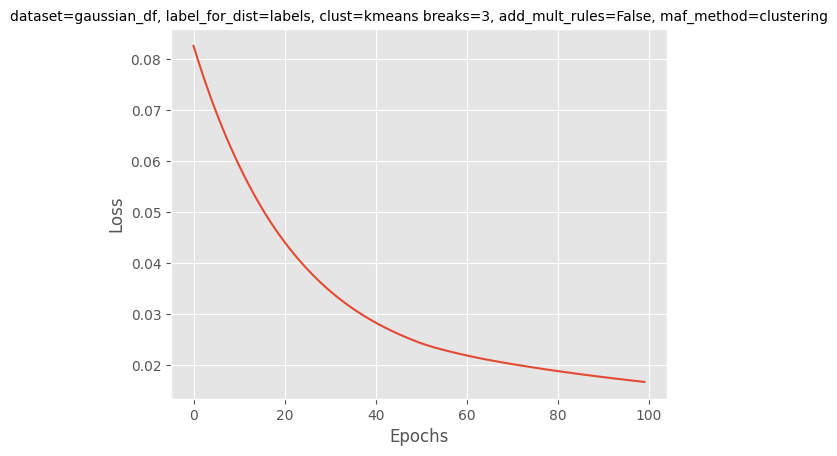

24-04-28 00:16:29 [DEBUG] Accuracy:  0.99
24-04-28 00:16:29 [DEBUG] F1 Score: 0.99
24-04-28 00:16:29 [DEBUG] Confusion Matrix: 
[[69  2]
 [ 0 79]]
24-04-28 00:16:29 [INFO] ------------------------------
24-04-28 00:16:29 [INFO] Step 5: Run DST (dataset=gaussian_df, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=random)
24-04-28 00:16:29 [DEBUG] 	Model init done


Optimization started
Processing epoch	238	0.0217	

24-04-28 00:17:49 [DEBUG] 	Model fit done
24-04-28 00:17:49 [INFO] Step 6: Inference done
24-04-28 00:17:49 [DEBUG] Training Time: 80.10s
24-04-28 00:17:49 [DEBUG] Epochs: 238
24-04-28 00:17:49 [DEBUG] Min Loss: 0.022



Training time: 80.10s, epochs: 238

Least training loss reached: 0.022
DSModelMultiQ(
  DS Classifier using 8 rules
  
  Rule 1: x < 0.321
  	C1: 0.000	C2: 0.767	Unc: 0.233
  
  Rule 2: 0.321 < x < 0.705
  	C1: 0.000	C2: 0.609	Unc: 0.391
  
  Rule 3: 0.705 < x < 1.089
  	C1: 0.742	C2: 0.000	Unc: 0.258
  
  Rule 4: x > 1.089
  	C1: 0.792	C2: 0.000	Unc: 0.208
  
  Rule 5: y < 0.228
  	C1: 0.636	C2: 0.000	Unc: 0.364
  
  Rule 6: 0.228 < y < 0.530
  	C1: 0.512	C2: 0.005	Unc: 0.482
  
  Rule 7: 0.530 < y < 0.833
  	C1: 0.004	C2: 0.510	Unc: 0.485
  
  Rule 8: y > 0.833
  	C1: 0.000	C2: 0.765	Unc: 0.235
)


Most important rules for class 0

	[0.792] R3: x > 1.089
			0: 0.792	1: 0.000	Unc: 0.208

	[0.742] R2: 0.705 < x < 1.089
			0: 0.742	1: 0.000	Unc: 0.258

	[0.636] R4: y < 0.228
			0: 0.636	1: 0.000	Unc: 0.364

	[0.515] R5: 0.228 < y < 0.530
			0: 0.512	1: 0.005	Unc: 0.482

Most important rules for class 1

	[0.767] R0: x < 0.321
			0: 0.000	1: 0.767	Unc: 0.233

	[0.765] R7: y > 0.833
			0

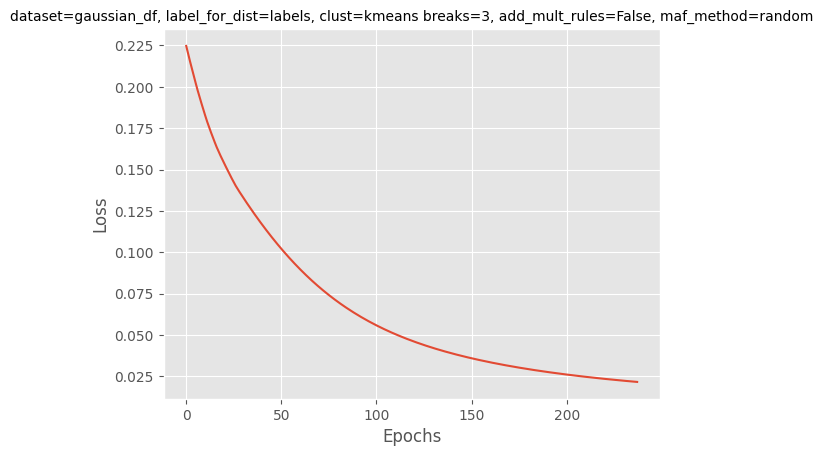

24-04-28 00:17:50 [DEBUG] Accuracy:  0.99
24-04-28 00:17:50 [DEBUG] F1 Score: 0.99
24-04-28 00:17:50 [DEBUG] Confusion Matrix: 
[[69  2]
 [ 0 79]]
24-04-28 00:17:50 [INFO] ------------------------------
 50%|█████     | 3/6 [13:04<10:33, 211.13s/it]24-04-28 00:17:50 [DEBUG] Dataset: rectangle_df | Shape: (1263, 3)
24-04-28 00:17:50 [DEBUG] (1263, 3) droped columns with more than 20% missing values
24-04-28 00:17:50 [DEBUG] (1263, 3) drop rows with missing values
24-04-28 00:17:50 [DEBUG] (1263, 3) drop non-numeric columns
24-04-28 00:17:50 [INFO] ------ Dataset: rectangle_df | Shape: (1263, 3) | Label ratio: 0.51 -------
24-04-28 00:17:50 [INFO] Step 0: Data split done | 884 - 379
24-04-28 00:17:50 [DEBUG] Step 1: Standard scaling complete
24-04-28 00:17:50 [INFO] Step 2.1: Performing kmeans clustering
24-04-28 00:17:50 [INFO] Step 2.1: Clustering and inference done
24-04-28 00:17:50 [DEBUG] Evaluation on train
24-04-28 00:17:50 [DEBUG] 	silhouette = 0.57
24-04-28 00:17:50 [DEBUG] 	cal

Optimization started
Processing epoch	167	0.0062	

24-04-28 00:20:03 [DEBUG] 	Model fit done
24-04-28 00:20:03 [INFO] Step 6: Inference done
24-04-28 00:20:03 [DEBUG] Training Time: 132.07s
24-04-28 00:20:03 [DEBUG] Epochs: 167
24-04-28 00:20:03 [DEBUG] Min Loss: 0.006



Training time: 132.07s, epochs: 167

Least training loss reached: 0.006
DSModelMultiQ(
  DS Classifier using 8 rules
  
  Rule 1: x < -0.403
  	C1: 0.305	C2: 0.406	Unc: 0.288
  
  Rule 2: -0.403 < x < -0.008
  	C1: 0.351	C2: 0.320	Unc: 0.330
  
  Rule 3: -0.008 < x < 0.388
  	C1: 0.374	C2: 0.308	Unc: 0.318
  
  Rule 4: x > 0.388
  	C1: 0.303	C2: 0.368	Unc: 0.328
  
  Rule 5: y < -0.452
  	C1: 0.935	C2: 0.000	Unc: 0.065
  
  Rule 6: -0.452 < y < -0.029
  	C1: 0.939	C2: 0.000	Unc: 0.061
  
  Rule 7: -0.029 < y < 0.393
  	C1: 0.000	C2: 0.882	Unc: 0.118
  
  Rule 8: y > 0.393
  	C1: 0.000	C2: 0.902	Unc: 0.098
)


Most important rules for class 0

	[0.939] R5: -0.452 < y < -0.029
			0: 0.939	1: 0.000	Unc: 0.061

	[0.935] R4: y < -0.452
			0: 0.935	1: 0.000	Unc: 0.065

	[0.505] R2: -0.008 < x < 0.388
			0: 0.374	1: 0.308	Unc: 0.318

	[0.485] R1: -0.403 < x < -0.008
			0: 0.351	1: 0.320	Unc: 0.330

	[0.466] R0: x < -0.403
			0: 0.305	1: 0.406	Unc: 0.288

	[0.451] R3: x > 0.388
			0: 0.303	1:

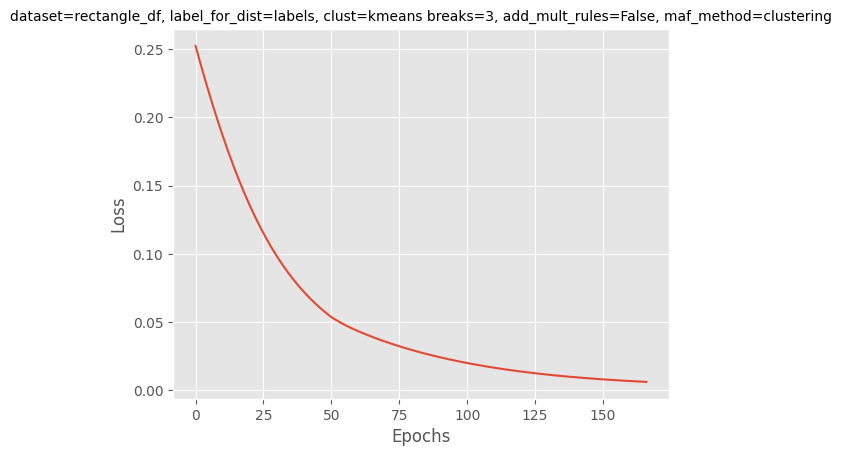

24-04-28 00:20:04 [DEBUG] Accuracy:  1.00
24-04-28 00:20:04 [DEBUG] F1 Score: 1.00
24-04-28 00:20:04 [DEBUG] Confusion Matrix: 
[[188   0]
 [  0 191]]
24-04-28 00:20:04 [INFO] ------------------------------
24-04-28 00:20:04 [INFO] Step 5: Run DST (dataset=rectangle_df, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=random)
24-04-28 00:20:04 [DEBUG] 	Model init done


Optimization started
Processing epoch	292	0.0081	

24-04-28 00:24:33 [DEBUG] 	Model fit done
24-04-28 00:24:34 [INFO] Step 6: Inference done
24-04-28 00:24:34 [DEBUG] Training Time: 269.33s
24-04-28 00:24:34 [DEBUG] Epochs: 292
24-04-28 00:24:34 [DEBUG] Min Loss: 0.008



Training time: 269.33s, epochs: 292

Least training loss reached: 0.008
DSModelMultiQ(
  DS Classifier using 8 rules
  
  Rule 1: x < -0.403
  	C1: 0.016	C2: 0.158	Unc: 0.826
  
  Rule 2: -0.403 < x < -0.008
  	C1: 0.035	C2: 0.152	Unc: 0.813
  
  Rule 3: -0.008 < x < 0.388
  	C1: 0.100	C2: 0.095	Unc: 0.805
  
  Rule 4: x > 0.388
  	C1: 0.039	C2: 0.148	Unc: 0.813
  
  Rule 5: y < -0.452
  	C1: 0.916	C2: 0.000	Unc: 0.084
  
  Rule 6: -0.452 < y < -0.029
  	C1: 0.911	C2: 0.000	Unc: 0.089
  
  Rule 7: -0.029 < y < 0.393
  	C1: 0.000	C2: 0.896	Unc: 0.104
  
  Rule 8: y > 0.393
  	C1: 0.000	C2: 0.884	Unc: 0.116
)


Most important rules for class 0

	[0.916] R4: y < -0.452
			0: 0.916	1: 0.000	Unc: 0.084

	[0.911] R5: -0.452 < y < -0.029
			0: 0.911	1: 0.000	Unc: 0.089

Most important rules for class 1

	[0.896] R6: -0.029 < y < 0.393
			0: 0.000	1: 0.896	Unc: 0.104

	[0.884] R7: y > 0.393
			0: 0.000	1: 0.884	Unc: 0.116


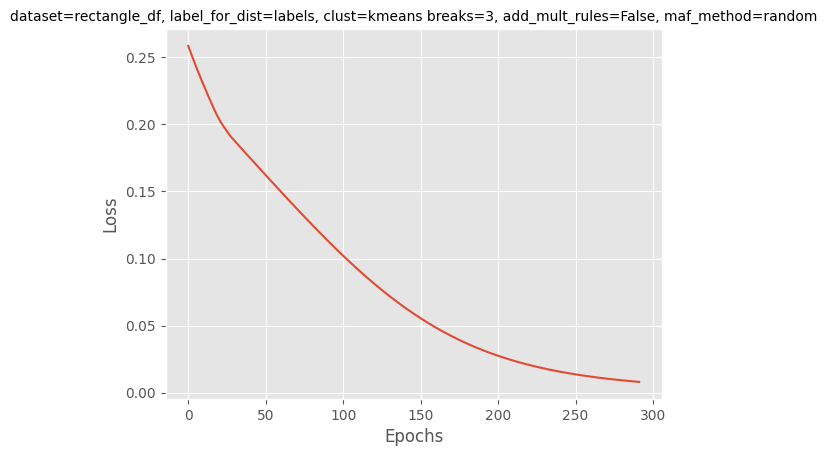

24-04-28 00:24:34 [DEBUG] Accuracy:  1.00
24-04-28 00:24:34 [DEBUG] F1 Score: 1.00
24-04-28 00:24:34 [DEBUG] Confusion Matrix: 
[[188   0]
 [  0 191]]
24-04-28 00:24:34 [INFO] ------------------------------
 67%|██████▋   | 4/6 [19:48<09:34, 287.31s/it]24-04-28 00:24:34 [DEBUG] Dataset: uniform_df | Shape: (500, 3)
24-04-28 00:24:34 [DEBUG] (500, 3) droped columns with more than 20% missing values
24-04-28 00:24:34 [DEBUG] (500, 3) drop rows with missing values
24-04-28 00:24:34 [DEBUG] (500, 3) drop non-numeric columns
24-04-28 00:24:34 [INFO] ------ Dataset: uniform_df | Shape: (500, 3) | Label ratio: 0.52 -------
24-04-28 00:24:34 [INFO] Step 0: Data split done | 350 - 150
24-04-28 00:24:34 [DEBUG] Step 1: Standard scaling complete
24-04-28 00:24:34 [INFO] Step 2.1: Performing kmeans clustering
24-04-28 00:24:34 [INFO] Step 2.1: Clustering and inference done
24-04-28 00:24:34 [DEBUG] Evaluation on train
24-04-28 00:24:34 [DEBUG] 	silhouette = 0.776
24-04-28 00:24:34 [DEBUG] 	calinsk

Optimization started
Processing epoch	119	0.0349	

24-04-28 00:24:59 [DEBUG] 	Model fit done


Processing epoch	120	0.0348	
Training time: 24.53s, epochs: 120

Least training loss reached: 0.035
DSModelMultiQ(
  DS Classifier using 5 rules
  
  Rule 1: x < -1.604
  	C1: 0.904	C2: 0.000	Unc: 0.096
  
  Rule 2: -1.604 < x < 0.281
  	C1: 0.768	C2: 0.000	Unc: 0.232
  
  Rule 3: 0.281 < x < 2.167
  	C1: 0.000	C2: 0.933	Unc: 0.067
  
  Rule 4: x > 2.167
  	C1: 0.000	C2: 0.933	Unc: 0.067
  
  Rule 5: y = 0.0
  	C1: 0.313	C2: 0.399	Unc: 0.288
)


Most important rules for class 0

	[0.904] R0: x < -1.604
			0: 0.904	1: 0.000	Unc: 0.096

	[0.768] R1: -1.604 < x < 0.281
			0: 0.768	1: 0.000	Unc: 0.232

	[0.472] R4: y = 0.0
			0: 0.313	1: 0.399	Unc: 0.288

Most important rules for class 1

	[0.933] R2: 0.281 < x < 2.167
			0: 0.000	1: 0.933	Unc: 0.067

	[0.933] R3: x > 2.167
			0: 0.000	1: 0.933	Unc: 0.067

	[0.533] R4: y = 0.0
			0: 0.313	1: 0.399	Unc: 0.288


24-04-28 00:24:59 [INFO] Step 6: Inference done
24-04-28 00:24:59 [DEBUG] Training Time: 24.53s
24-04-28 00:24:59 [DEBUG] Epochs: 120
24-04-28 00:24:59 [DEBUG] Min Loss: 0.035


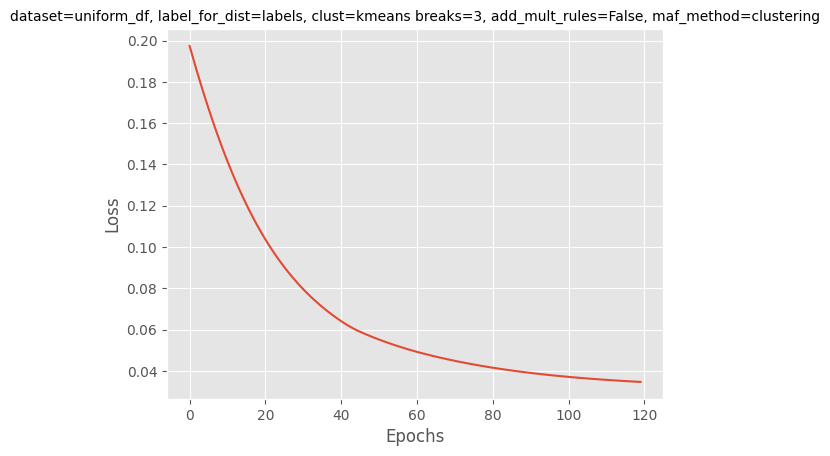

24-04-28 00:25:00 [DEBUG] Accuracy:  0.97
24-04-28 00:25:00 [DEBUG] F1 Score: 0.97
24-04-28 00:25:00 [DEBUG] Confusion Matrix: 
[[82  0]
 [ 4 64]]
24-04-28 00:25:00 [INFO] ------------------------------
24-04-28 00:25:00 [INFO] Step 5: Run DST (dataset=uniform_df, label_for_dist=labels, clust=kmeans breaks=3, add_mult_rules=False, maf_method=random)
24-04-28 00:25:00 [DEBUG] 	Model init done


Optimization started
Processing epoch	264	0.0375	

24-04-28 00:26:02 [DEBUG] 	Model fit done
24-04-28 00:26:02 [INFO] Step 6: Inference done
24-04-28 00:26:02 [DEBUG] Training Time: 62.24s
24-04-28 00:26:02 [DEBUG] Epochs: 264
24-04-28 00:26:02 [DEBUG] Min Loss: 0.037



Training time: 62.24s, epochs: 264

Least training loss reached: 0.037
DSModelMultiQ(
  DS Classifier using 5 rules
  
  Rule 1: x < -1.604
  	C1: 0.905	C2: 0.000	Unc: 0.095
  
  Rule 2: -1.604 < x < 0.281
  	C1: 0.780	C2: 0.000	Unc: 0.220
  
  Rule 3: 0.281 < x < 2.167
  	C1: 0.000	C2: 0.889	Unc: 0.111
  
  Rule 4: x > 2.167
  	C1: 0.000	C2: 0.876	Unc: 0.124
  
  Rule 5: y = 0.0
  	C1: 0.004	C2: 0.189	Unc: 0.806
)


Most important rules for class 0

	[0.905] R0: x < -1.604
			0: 0.905	1: 0.000	Unc: 0.095

	[0.780] R1: -1.604 < x < 0.281
			0: 0.780	1: 0.000	Unc: 0.220

Most important rules for class 1

	[0.889] R2: 0.281 < x < 2.167
			0: 0.000	1: 0.889	Unc: 0.111

	[0.876] R3: x > 2.167
			0: 0.000	1: 0.876	Unc: 0.124


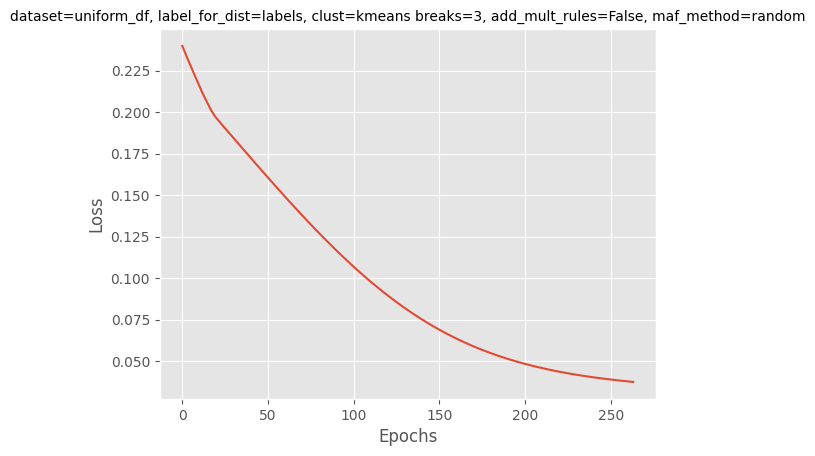

24-04-28 00:26:03 [DEBUG] Accuracy:  0.97
24-04-28 00:26:03 [DEBUG] F1 Score: 0.97
24-04-28 00:26:03 [DEBUG] Confusion Matrix: 
[[82  0]
 [ 4 64]]
24-04-28 00:26:03 [INFO] ------------------------------
 83%|████████▎ | 5/6 [21:17<03:35, 215.80s/it]24-04-28 00:26:03 [DEBUG] Dataset: wine | Shape: (6497, 14)
24-04-28 00:26:03 [DEBUG] (6497, 14) droped columns with more than 20% missing values
24-04-28 00:26:03 [DEBUG] (6497, 14) drop rows with missing values
24-04-28 00:26:03 [INFO] ################################################################################
24-04-28 00:26:03 [ERROR] Error for dataset wine.csv: Label ratio is not balanced (0.8034477451131291)
24-04-28 00:26:03 [INFO] ################################################################################
100%|██████████| 6/6 [21:17<00:00, 212.98s/it]


In [16]:
from tqdm import tqdm
for dataset in tqdm(datasets):
    try:
        do_all_for_dataset(dataset, nrows=None, ratio_deviation=0.2)
    except Exception as e:
        logging.info("#"*80)
        logging.error(f"Error for dataset {dataset}: {e}")
        logging.info("#"*80)
        continue

# Reading the data

## Load the dataset, make checks

In [4]:
dataset = datasets[1]
dataset_name = dataset.split(".")[0]

data = pd.read_csv(os.path.join(DATASET_FOLDER, dataset))#.head(2000)

logger.debug(f"Dataset: {dataset_name} | Shape: {data.shape}")
# if missing more than 20% of the data, drop the column
missing_threshold = 0.2
data = data.dropna(thresh=len(data) * (1 - missing_threshold), axis=1)
logger.debug(f"{data.shape} droped columns with more than {missing_threshold*100:.0f}% missing values")
# drop rows with missing values
data = data.dropna()
logger.debug(f"{data.shape} drop rows with missing values")

assert data.isna().sum().sum() == 0, "Dataset contains missing values"
assert "labels" in data.columns, "Dataset does not contain `labels` column"
assert data.labels.nunique() == 2, "Dataset labels are not binary"

label_ratio = data.labels.value_counts(normalize=True).iloc[0]
assert 0.4 < label_ratio < 0.6, "Label ratio is not balanced"


# leave only numeric columns
data = data.select_dtypes(include=[np.number])
logger.debug(f"{data.shape} drop non-numeric columns")

# move labels column to the end 
data = data[[col for col in data.columns if col != "labels"] + ["labels"]]

logging.info(f"------ Dataset: {dataset_name} | Shape: {data.shape} | Label ratio: {label_ratio:.2f} -------")

24-04-27 21:39:53 [DEBUG] Dataset: Telecom_customer churn | Shape: (100000, 99)
24-04-27 21:39:54 [DEBUG] (100000, 90) droped columns with more than 20% missing values
24-04-27 21:39:55 [DEBUG] (78334, 90) drop rows with missing values
24-04-27 21:39:55 [DEBUG] (78334, 74) drop non-numeric columns
24-04-27 21:39:56 [INFO] ------ Dataset: Telecom_customer churn | Shape: (78334, 74) | Label ratio: 0.52 -------


## Train test split

In [5]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data = data.apply(pd.to_numeric)
cut = int(train_set_size*len(data))

train_data_df = data.iloc[:cut]
test_data_df = data.iloc[cut:]

X_train = data.iloc[:cut, :-1].values
y_train = data.iloc[:cut, -1].values
X_test = data.iloc[cut:, :-1].values
y_test = data.iloc[cut:, -1].values

logging.info(f"Step 0: Data split done | {len(X_train)} - {len(X_test)}")


24-04-27 21:39:56 [INFO] Step 0: Data split done | 54833 - 23501


## Scaling

In [6]:
st_scaler = StandardScaler().fit(train_data_df)
# break
scale = st_scaler.scale_
mean = st_scaler.mean_
var = st_scaler.var_ 

X_train_scaled = st_scaler.transform(train_data_df)
X_test_scaled = st_scaler.transform(test_data_df)  #! during inference we won't have this

logging.debug("Step 1: Standard scaling complete")

24-04-27 21:39:57 [DEBUG] Step 1: Standard scaling complete


## Clustering

### Fitting and Inference

In [8]:

CLUSTERING_ALG = "dbscan" # in future we'll add DBSCAN
# CLUSTERING_ALG = "kmeans" # in future we'll add DBSCAN

logging.info(f"Step 2.1: Performing {CLUSTERING_ALG} clustering")



if CLUSTERING_ALG == "kmeans":
    clustering_model = KMeans(n_clusters=2, random_state=42, n_init="auto")      
    clustering_model.fit(X_train_scaled)  
    
    clustering_labels_train = clustering_model.predict(X_train_scaled)
    clustering_labels_test = clustering_model.predict(X_test_scaled)
else:
    clustering_model = run_dbscan(X_train_scaled, eps=0.01, max_eps=20, min_samples=2, step=0.05) #*X_train.shape[1] - 1)
    if clustering_model is None:
        logging.warning(f"Could not find the desired number of clusters for {dataset_name}")
        raise Exception("Clustering failed")
    
    clustering_labels_train = dbscan_predict(clustering_model, X_train_scaled)
    clustering_labels_test = dbscan_predict(clustering_model, X_test_scaled)
    
    db_eps = clustering_model.eps
    


train_data_df["labels_clustering"] = clustering_labels_train
test_data_df["labels_clustering"] = clustering_labels_test

logger.info(f"Step 2.1: Clustering and inference done")

24-04-27 23:58:02 [INFO] Step 2.1: Performing dbscan clustering


NameError: name 'X_train_scaled' is not defined

## Evaluation (silhouette, ...)

In [ ]:
evaluate_clustering(X_train_scaled, clustering_labels_train, clustering_model, 
                    CLUSTERING_ALG, print_results=True)
evaluate_clustering(X_test_scaled, clustering_labels_test, clustering_model, 
                    CLUSTERING_ALG, print_results=True, dataset="test")

logging.info("Step 2.2: Clustering evaluation done")

24-04-27 20:02:40 [DEBUG] Evaluation on train
24-04-27 20:02:40 [DEBUG] 	silhouette = 0.46
24-04-27 20:02:40 [DEBUG] 	calinski_harabasz = 127.522
24-04-27 20:02:40 [DEBUG] Evaluation on test
24-04-27 20:02:40 [DEBUG] 	silhouette = 0.567
24-04-27 20:02:40 [DEBUG] 	calinski_harabasz = 139.743
24-04-27 20:02:40 [INFO] Step 2.2: Clustering evaluation done


## Clustering evaluation (as pseudo clsassifier)

In [ ]:
evaluate_classifier(y_actual=y_train, y_clust=clustering_labels_train, 
                    dataset="train", print_results=True)
evaluate_classifier(y_actual=y_test, y_clust=clustering_labels_test, 
                    dataset="test", print_results=True)

logger.info("Step 3: Clustering as a classifier, evaluation done")

24-04-27 20:02:40 [DEBUG] Evaluation on train
24-04-27 20:02:40 [DEBUG] 	Accuracy:  0.51
24-04-27 20:02:40 [DEBUG] 	F1 Score: 0.65
24-04-27 20:02:40 [DEBUG] 	Confusion Matrix: 
[[ 66 487]
 [ 38 489]]
24-04-27 20:02:40 [DEBUG] Evaluation on test
24-04-27 20:02:40 [DEBUG] 	Accuracy:  0.51
24-04-27 20:02:40 [DEBUG] 	F1 Score: 0.64
24-04-27 20:02:40 [DEBUG] 	Confusion Matrix: 
[[ 33 213]
 [ 16 201]]
24-04-27 20:02:40 [INFO] Step 3: Clustering as a classifier, evaluation done


## Distance calculation

In [ ]:
db_eps

7.95999999999998

In [ ]:
train_data_df["distance"] = get_distance(X_train_scaled, clustering_model, CLUSTERING_ALG, density_radius=db_eps)
test_data_df["distance"] = get_distance(X_test_scaled, clustering_model, CLUSTERING_ALG, density_radius=db_eps)

In [ ]:
train_data_df["distance_norm"] = remove_outliers_and_normalize(train_data_df, label_column="labels_clustering") 
test_data_df["distance_norm"] = remove_outliers_and_normalize(test_data_df, label_column="labels_clustering")

assert train_data_df.isna().sum().sum() == 0, "Train data contains NaNs"
assert test_data_df.isna().sum().sum() == 0, "Train data contains NaNs"

logger.info(f"Step 4: Distance calculation done")

24-04-27 20:02:41 [INFO] Step 4: Distance calculation done


## DST

In [ ]:
# !pip install -U kaleido
print(1)

1


24-04-27 20:03:06 [DEBUG] Train: 1080
24-04-27 20:03:06 [INFO] Step 5: Run DST (dataset=Telecom_customer churn, clust=dbscan breaks=3, add_mult_rules=False, maf_method=clustering)
24-04-27 20:03:06 [DEBUG] 	Model init done


Optimization started
Processing epoch	9	0.3493	

24-04-27 20:03:25 [DEBUG] 	Model fit done



Training time: 4.52s, epochs: 9

Least training loss reached: 0.352
DSModelMultiQ(
  DS Classifier using 302 rules
  
  Rule 1: rev_Mean < 32.278
  	C1: 0.191	C2: 0.571	Unc: 0.238
  
  Rule 2: 32.278 < rev_Mean < 67.108
  	C1: 0.570	C2: 0.233	Unc: 0.197
  
  Rule 3: 67.108 < rev_Mean < 101.937
  	C1: 0.745	C2: 0.116	Unc: 0.139
  
  Rule 4: rev_Mean > 101.937
  	C1: 0.934	C2: 0.020	Unc: 0.046
  
  Rule 5: mou_Mean < 137.502
  	C1: 0.194	C2: 0.563	Unc: 0.243
  
  Rule 6: 137.502 < mou_Mean < 588.828
  	C1: 0.157	C2: 0.606	Unc: 0.237
  
  Rule 7: 588.828 < mou_Mean < 1040.153
  	C1: 0.725	C2: 0.116	Unc: 0.159
  
  Rule 8: mou_Mean > 1040.153
  	C1: 0.949	C2: 0.014	Unc: 0.037
  
  Rule 9: totmrc_Mean < 29.970
  	C1: 0.181	C2: 0.569	Unc: 0.250
  
  Rule 10: 29.970 < totmrc_Mean < 51.264
  	C1: 0.151	C2: 0.655	Unc: 0.194
  
  Rule 11: 51.264 < totmrc_Mean < 72.558
  	C1: 0.674	C2: 0.184	Unc: 0.143
  
  Rule 12: totmrc_Mean > 72.558
  	C1: 0.870	C2: 0.055	Unc: 0.075
  
  Rule 13: da_Mean < -

24-04-27 20:03:26 [INFO] Step 6: Inference done
24-04-27 20:03:26 [DEBUG] Training Time: 4.52s
24-04-27 20:03:26 [DEBUG] Epochs: 9
24-04-27 20:03:26 [DEBUG] Min Loss: 0.352
24-04-27 20:03:26 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.
24-04-27 20:03:26 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.


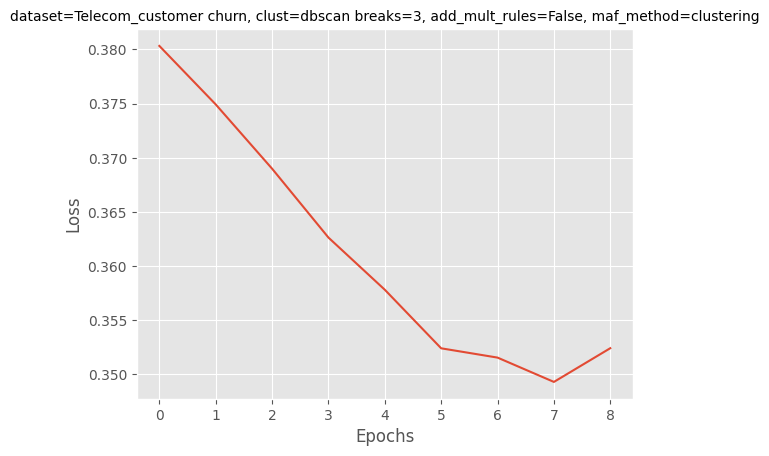

24-04-27 20:03:26 [DEBUG] Accuracy:  0.57
24-04-27 20:03:26 [DEBUG] F1 Score: 0.37
24-04-27 20:03:26 [DEBUG] Confusion Matrix: 
[[204  42]
 [159  58]]
24-04-27 20:03:26 [INFO] ------------------------------
24-04-27 20:03:26 [INFO] Step 5: Run DST (dataset=Telecom_customer churn, clust=dbscan breaks=3, add_mult_rules=False, maf_method=random)
24-04-27 20:03:26 [DEBUG] 	Model init done


Optimization started
Processing epoch	127	0.1849	

24-04-27 20:04:28 [DEBUG] 	Model fit done



Training time: 61.70s, epochs: 127

Least training loss reached: 0.185
DSModelMultiQ(
  DS Classifier using 302 rules
  
  Rule 1: rev_Mean < 32.278
  	C1: 0.139	C2: 0.045	Unc: 0.816
  
  Rule 2: 32.278 < rev_Mean < 67.108
  	C1: 0.056	C2: 0.138	Unc: 0.806
  
  Rule 3: 67.108 < rev_Mean < 101.937
  	C1: 0.171	C2: 0.020	Unc: 0.809
  
  Rule 4: rev_Mean > 101.937
  	C1: 0.000	C2: 0.234	Unc: 0.766
  
  Rule 5: mou_Mean < 137.502
  	C1: 0.000	C2: 0.210	Unc: 0.790
  
  Rule 6: 137.502 < mou_Mean < 588.828
  	C1: 0.000	C2: 0.235	Unc: 0.765
  
  Rule 7: 588.828 < mou_Mean < 1040.153
  	C1: 0.380	C2: 0.000	Unc: 0.620
  
  Rule 8: mou_Mean > 1040.153
  	C1: 0.361	C2: 0.000	Unc: 0.639
  
  Rule 9: totmrc_Mean < 29.970
  	C1: 0.000	C2: 0.271	Unc: 0.729
  
  Rule 10: 29.970 < totmrc_Mean < 51.264
  	C1: 0.014	C2: 0.179	Unc: 0.807
  
  Rule 11: 51.264 < totmrc_Mean < 72.558
  	C1: 0.025	C2: 0.159	Unc: 0.816
  
  Rule 12: totmrc_Mean > 72.558
  	C1: 0.340	C2: 0.000	Unc: 0.660
  
  Rule 13: da_Mean 

24-04-27 20:04:29 [INFO] Step 6: Inference done
24-04-27 20:04:29 [DEBUG] Training Time: 61.70s
24-04-27 20:04:29 [DEBUG] Epochs: 127
24-04-27 20:04:29 [DEBUG] Min Loss: 0.185


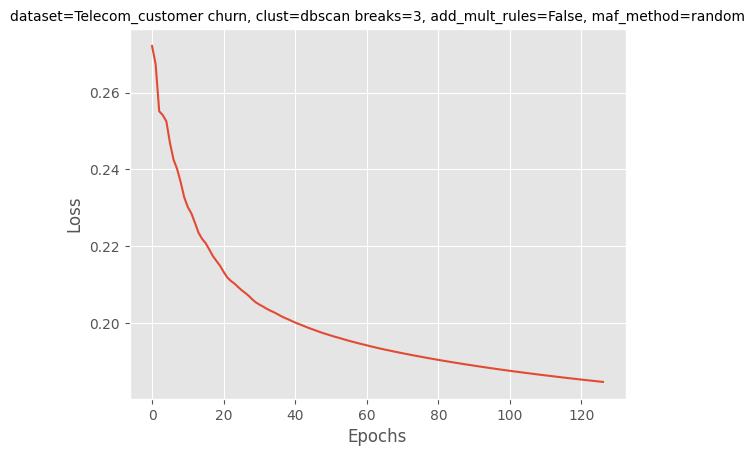

24-04-27 20:04:29 [DEBUG] Accuracy:  0.61
24-04-27 20:04:29 [DEBUG] F1 Score: 0.59
24-04-27 20:04:29 [DEBUG] Confusion Matrix: 
[[150  96]
 [ 85 132]]
24-04-27 20:04:29 [INFO] ------------------------------


In [ ]:
num_breaks = 3
mult_rules = False
debug_mode = True
print_final_model = True
num_workers = 0

RULE_FOLDER = "rules_saved_clean"

ignore_for_training = ["labels_clustering", "distance_norm"]
df_cols = [i for i in list(data.columns) if i not in ignore_for_training]

rows_use = None
if rows_use:
    train_data_df_use = train_data_df.head(rows_use)
    X_train_use = X_train[:rows_use]
    y_train_use = y_train[:rows_use]
else:
    train_data_df_use = train_data_df
    X_train_use = X_train
    y_train_use = y_train
logger.debug(f"Train: {len(X_train_use)}")
for method in ["clustering", "random"]:
    name = f"dataset={dataset_name}, clust={CLUSTERING_ALG} breaks={num_breaks}, add_mult_rules={mult_rules}, maf_method={method}"
    logger.info(f"Step 5: Run DST ({name})")
    DSC = DSClassifierMultiQ(2, debug_mode=debug_mode, num_workers=num_workers, maf_method=method,
                            data=train_data_df_use, precompute_rules=True, )#.head(rows_use))
    logger.debug(f"\tModel init done")    
    res = DSC.fit(X_train_use, y_train_use, 
            add_single_rules=True, single_rules_breaks=num_breaks, add_mult_rules=mult_rules,
            column_names=df_cols, print_every_epochs=1, print_final_model=print_final_model)
    losses, epoch, dt = res
    logger.debug(f"\tModel fit done")

    DSC.model.save_rules_bin(os.path.join(RULE_FOLDER, f"{name}.dsb"))
#     most_important_rules = DSC.model.find_most_important_rules()
#     print(most_important_rules)
    DSC.model.print_most_important_rules()
    y_pred = DSC.predict(X_test)

    logger.info(f"Step 6: Inference done")

    report_results(y_test, y_pred, dataset=dataset_name, method=method,
                epoch=epoch, dt=dt, losses=losses, 
                save_results=True, name=name, print_results=True,
                breaks=num_breaks, mult_rules=mult_rules, )
    
    logging.info("-"*30)
    
    

In [ ]:
filter_by_rule(train_data_df_use, lambda x: x["rev_Mean"] < 32.278, print_results=True)

24-04-27 19:58:28 [DEBUG] Number of data points left after filtering: 262
24-04-27 19:58:28 [DEBUG] Number of clusters left after filtering: 2
24-04-27 19:58:28 [DEBUG] Most common cluster: 1
24-04-27 19:58:28 [DEBUG] Data points belong to different clusters
24-04-27 19:58:28 [DEBUG] Confidence: 0.21651189312479646
24-04-27 19:58:28 [DEBUG] Confidence after lowering based on proportion: 0.5364860436425323


(0.2317569781787339, 0.5364860436425323, 0.2317569781787339)

AttributeError: 'Axes' object has no attribute 'isna'

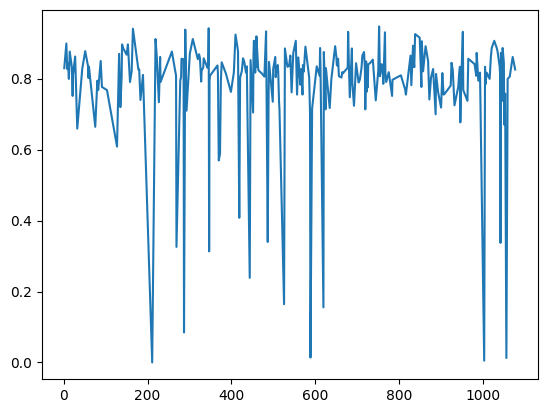

In [ ]:
train_data_df_use.query("rev_Mean < 32.278").distance_norm.plot().isna().sum()

In [ ]:
experiments = pd.read_csv("experiments.csv")

experiments.tail(2)

,name,accuracy,f1,confusion_matrix,training_time,epochs,min_loss,datetime,MAF method,dataset,breaks,mult_rules
84,"dataset=Brain Tumor, breaks=3, add_mult_rules=...",0.975199,0.970833,[[635 9]\n [ 19 466]],288.094734,69,0.033078,26-04-2024 21:24:14,kmeans,Brain Tumor,3.0,False
85,"dataset=Brain Tumor, breaks=3, add_mult_rules=...",0.982285,0.979339,[[635 9]\n [ 11 474]],394.811531,137,0.026403,26-04-2024 21:30:50,random,Brain Tumor,3.0,False


## Rules

In [34]:
RULE_FOLDER = "rules_saved_clean"

assert os.path.exists(RULE_FOLDER), f"Folder {RULE_FOLDER} does not exist"

rules = os.listdir(RULE_FOLDER)
logging.info(f"Found {len(rules)} rules")

24-04-26 21:41:45 [INFO] Found 4 rules


In [35]:
def get_pairs(rules):
    pairs = []
    for rule1 in rules:
        if 'maf_method' in rule1:
            for rule2 in rules:
                if rule1 == rule2 or (rule2, rule1) in pairs:
                    continue
                if rule2.startswith(rule1.split('maf_method')[0]):
                    pairs.append((rule1, rule2))
    return pairs

In [36]:
def extract_res(rules_info):
    rules = rules_info["preds"]
    mafs = rules_info["masses"]
    
    rule_names = [str(i) for i in rules]
    mass_first = [float(i[0]) for i in mafs]
    mass_second = [float(i[1]) for i in mafs]
    uncertainty = [float(i[2]) for i in mafs]
    
    res = {"rule": rule_names, "mass_first": mass_first, "mass_second": mass_second, "uncertainty": uncertainty}
    return res

In [39]:
pairs = get_pairs(rules)

dfs = {}

for r1, r2 in pairs:
    r1_info = pickle.load(open(os.path.join(RULE_FOLDER, r1), "rb"))
    r2_info = pickle.load(open(os.path.join(RULE_FOLDER, r2), "rb"))
    
    r1_df = pd.DataFrame(extract_res(r1_info))
    r2_df = pd.DataFrame(extract_res(r2_info))
    
    
    merged = pd.merge(r1_df, r2_df, on="rule", suffixes=('_kmeans', '_random'))
    merged.to_csv(f"rules_{r1}_{r2}.csv", index=False)

    print(f"Num rules {len(merged)}")
    fig = px.bar(merged, x='rule', y=['uncertainty_kmeans', 'uncertainty_random'], 
        title='Uncertainty comparison between kmeans and random', # put bars next to each other
        barmode='group')
    fig.write_html(f"{r1}_{r2}.html")
    dfs[r1] = merged 
    fig.show()

Num rules 49


Num rules 205


In [55]:
ks = list(dfs.keys())
print(ks)
a = dfs[ks[1]]


a["Uncertainty ratio"]  = a["uncertainty_random"] / a["uncertainty_kmeans"]

# remove inf
res = a["Uncertainty ratio"] 
res.replace([np.inf, -np.inf, ""], np.nan, inplace=True)

res = a["Uncertainty ratio"].dropna()

res.describe().round(3).to_clipboard()

['dataset=Brain Tumor, breaks=3, add_mult_rules=False, maf_method=kmeans.dsb', 'dataset=Brain Tumor, breaks=3, add_mult_rules=True, maf_method=kmeans.dsb']


In [47]:
a["Uncertainty ratio"].dropna()

0      1.950997
1      2.039998
2      2.296427
3      5.962318
4      2.055425
5      2.271974
6      2.257644
7      2.475599
8      2.068167
9      2.035401
10     2.328404
11     2.335880
12          inf
13     2.287148
14     1.489149
15     1.555324
16     1.407726
17     2.373192
18     2.151206
19     1.607796
20     0.800000
21     2.002392
22     2.090169
23     1.189022
24     2.078127
25     2.271453
26    11.785043
27     2.108319
28          inf
29    81.841992
30     1.546927
31     1.712679
32          inf
33     2.370462
34     1.966143
35     1.921688
36          inf
37     1.557658
38     1.915628
39     1.645202
40     2.094582
41     2.243877
42     2.615344
43     1.885207
44     2.361644
45     2.370196
46     1.955638
47     2.339852
48     5.545559
Name: Uncertainty ratio, dtype: float64

In [31]:

print(f"Num rules {len(merged)}")

Num rules 205


In [71]:
px.bar(merged, x='rule', y=['uncertainty_kmeans', 'uncertainty_random'], 
       title='Uncertainty comparison between kmeans and random', # put bars next to each other
       barmode='group')

# Misc

In [25]:
df_  = pd.read_csv(r"datasets\breast-cancer-wisconsin.csv")
df_["labels"] = df_["labels"].replace({2: 0, 4: 1})
df_.to_csv(r"datasets\breast-cancer-wisconsin.csv", index=False)